In [1]:
import os
import sys
import trace
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib import cm, ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Dict, Tuple

root_dir = os.environ.get("ROOT_PATH")
if not root_dir in sys.path: sys.path.append(root_dir)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.logging_config import get_logger

from src.filepaths import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

from dotenv import load_dotenv
load_dotenv(override=True)

# Get environment variables from .env file
ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

# Create boolean from FP_FIT_METHOD value
USE_FULL_FN = True if FP_FIT_METHOD == 0 else False

In [2]:
# Load FP fits (combined FP)
fp_fits = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["ALL_COMBINED"]
fp_fits["c"] = fp_fits["rmean"] - fp_fits["a"] * fp_fits["smean"] - fp_fits["b"] * fp_fits["imean"]
a = fp_fits["a"]
b = fp_fits["b"]
c = fp_fits["c"]

# Load LAMOST data and calculate residual
df = pd.read_csv("../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/lamost.csv")
df["r_fp"] = fp_fits["a"] * df["s"] + fp_fits["b"] * df["i"] + fp_fits["c"]
df["fp_residual"] = df["r"] - df["r_fp"]

# Load stellar ages from external data
columns = ["obsid", "ra", "dec", "z", "SNr", "r_p", "log_age", "metallicity"]
df_ages = pd.read_csv("../data/external/lamost_ages/table1.dat", delim_whitespace=True, names=columns)
df_ages["obsid"] = df_ages["obsid"].apply(lambda x: "LAMOST" + str(x))
df_ages["log_age"] -= 9

# Merge based on obsid
df = pd.merge(df[["obsid", "r", "s", "i", "r_fp", "fp_residual"]], df_ages, on="obsid")

# # Plot FP edge-on
# r_ = np.array([df["r"].values, df["s"].values, df["i"].values]).T# -  np.array([fp_fits["rmean"], fp_fits["smean"], fp_fits["imean"]])
# v1 = np.array([1, -a, -b])/np.sqrt(1 + a**2 + b**2)
# v2 = np.array([1, 0, 1/b]) * b / np.sqrt(1 + b**2)
# v3 = np.array([-a, -(1 + b**2), a * b]) / np.sqrt((1 + b**2) * (1 + a**2 + b**2))

# x = np.dot(r_, v1)
# y = np.dot(r_, v3)
# z = np.dot(r_, v2)

# plt.scatter(x, y)

In [5]:
pd.read_csv("../data/external/lamost_ages/table1.dat", delim_whitespace=True, names=columns)

,obsid,ra,dec,z,SNr,r_p,log_age,metallicity
0,172710188,0.006891,47.274663,0.016737,26.48,-9999.000,9.466,0.003
1,505906171,0.011499,4.042058,0.148124,14.52,17.701,9.873,-0.194
2,505913176,0.012112,5.598717,0.039832,18.13,16.869,9.834,-0.418
3,369915182,0.012786,8.920771,0.097185,18.85,16.873,10.051,-0.280
4,369905145,0.013150,6.838217,0.074086,12.63,16.417,8.812,-0.772
...,...,...,...,...,...,...,...,...
42880,472905243,359.986531,16.654209,0.113689,9.53,17.316,9.652,-0.158
42881,369215021,359.987380,3.877171,0.089031,18.22,17.093,9.460,-0.078
42882,472916148,359.989786,19.539509,0.090586,7.10,17.416,10.022,0.022
42883,369915041,359.990550,9.244397,0.098302,23.44,16.085,9.270,-0.111


Text(0, 0.5, '$\\log_{10}R_e$ [$h^{-1}$ kpc]')

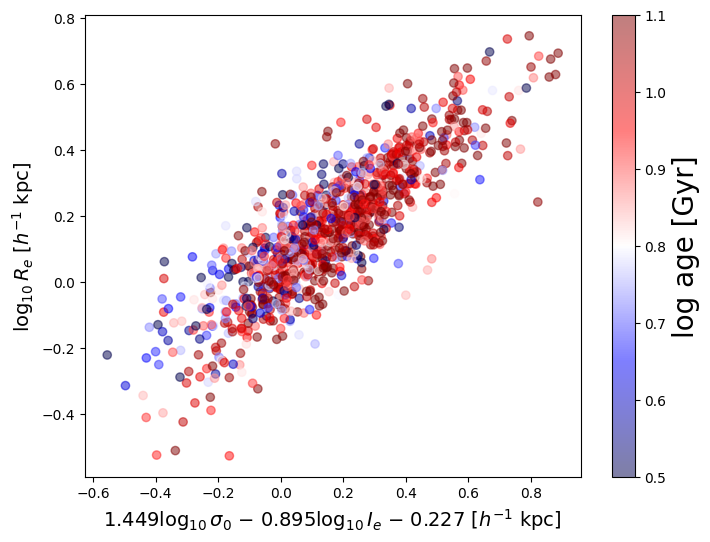

In [4]:
r_label = r'$\log_{10}R_e$'
r_unit = r'$h^{-1}$ kpc'
s_label = r'$\log_{10}\sigma_0$'
s_unit = r'$\mathrm{km}\ \mathrm{s}^{-1}$'
i_label = r'$\log_{10}I_e$'
i_unit = r'$\mathrm{L}_\odot\ \mathrm{pc}^{-2}$'

# Plot edge-on FP colour coded by log_age
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(df["r_fp"], df["r"], c=df["log_age"], cmap="seismic", vmin=0.5, vmax=1.1, alpha=0.5)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(label=r'log age [Gyr]', fontsize=20)
ax.set_xlabel(rf'{np.round(a, 3)}{s_label} $-$ {np.absolute(np.round(b, 3))}{i_label} $-$ {np.absolute(np.round(c, 3))} [{r_unit}]', fontsize=14)
ax.set_ylabel(f'{r_label} [{r_unit}]', fontsize=14)

### LOESS smoothing

Text(0, 0.5, '$\\log_{10}R_e$ [$h^{-1}$ kpc]')

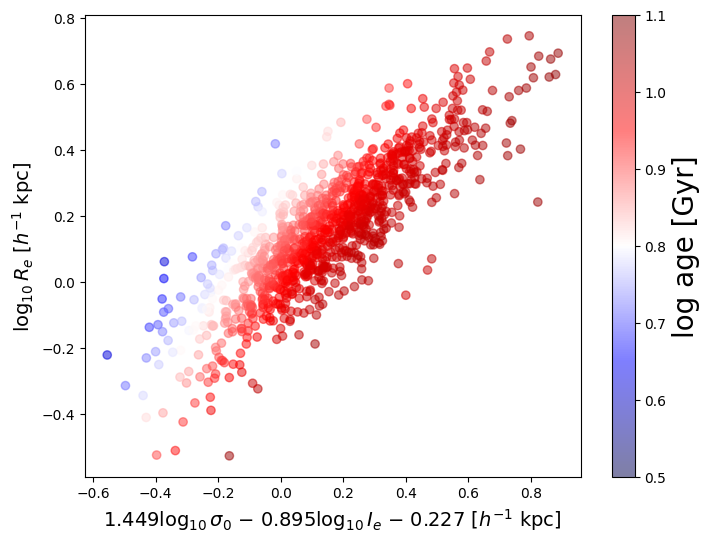

In [13]:
from loess.loess_2d import loess_2d

x = df["r_fp"].to_numpy()
y = df["r"].to_numpy()
z = df["log_age"].to_numpy()

zout, wout = loess_2d(x, y, z, xnew=None, ynew=None, degree=1, frac=0.8,
                      npoints=None, rescale=False, sigz=None)

# Plot edge-on FP colour coded by log_age
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(x, y, c=zout, cmap="seismic", vmin=0.5, vmax=1.1, alpha=0.5)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label(label=r'log age [Gyr]', fontsize=20)
ax.set_xlabel(rf'{np.round(a, 3)}{s_label} $-$ {np.absolute(np.round(b, 3))}{i_label} $-$ {np.absolute(np.round(c, 3))} [{r_unit}]', fontsize=14)
ax.set_ylabel(f'{r_label} [{r_unit}]', fontsize=14)

### Try plot actual edge-on view

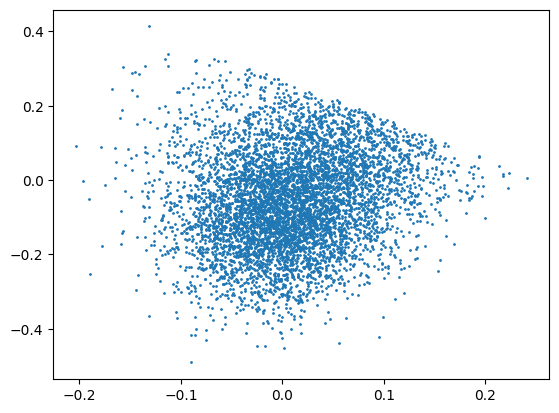

In [101]:
# Load FP fits (combined FP)
fp_fits = pd.read_csv("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0).loc["6dFGS"]
fp_fits["c"] = fp_fits["rmean"] - fp_fits["a"] * fp_fits["smean"] - fp_fits["b"] * fp_fits["imean"]
a = fp_fits["a"]
b = fp_fits["b"]
c = fp_fits["c"]

# Load LAMOST data and calculate residual
df = pd.read_csv("../data/foundation/fp_sample_final/smin_setting_1/fp_fit_method_0/6dfgs.csv")

# Plot FP edge-on
r_ = np.array([df["r"].values, df["s"].values, df["i"].values]).T -  np.array([fp_fits["rmean"], fp_fits["smean"], fp_fits["imean"]])
v1_mag = np.sqrt(1 + a**2 + b**2)
v2_mag = np.sqrt(1 + b**2)
v1 = np.array([1, -a, -b]) / v1_mag
v2 = np.array([b, 0, 1]) / v2_mag
v3 = np.array([-a, -(1 + b**2), a * b]) / (v1_mag * v2_mag)

# Project onto eigenvectors
x = np.dot(r_, v2) # short axis
y = np.dot(r_, v1) # long axis
z = np.dot(r_, v3) # across axis

plt.scatter(y, z, s=1)